### Notebook for creating the combined observed & modelled CI plot

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import rasterio
import geopandas as gpd
import pycountry
import numpy as np
import yaml
import os
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import matplotlib as mpl
from adjustText import adjust_text

#### Define Functions

In [44]:
def combine_national_observed_metrics(country_list):
    '''
    Function for combining national metrics into one geodataframe.
    Function takes as input:
        - the list of countries to combine (ISO3 codes)
    '''
    # List to store individual GeoDataFrames
    gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            metric_path = os.path.join("..", "data", "results", "social_flood", "countries", f"{country}",
                                       "inequality_metrics", f"{country}_ADM0_decomposed_metrics_gfd-flood_S-rwi.gpkg")
            # Read the GeoPackage
            gdf = gpd.read_file(metric_path)
            # Append to list
            gdfs.append(gdf)
        except Exception as e:
            print(f"Error processing {country}: {e}")
    
    # Combine all GeoDataFrames
    if gdfs:
        combined_gdf = pd.concat(gdfs, ignore_index=True)
        return combined_gdf
    else:
        print("No valid data found")

def combine_national_inequality_metrics(country_list, model, metric, vuln_curve):
    '''
    Function for combining national metrics into one geodataframe.
    Function takes as input:
        - the list of countries to combine (ISO3 codes)
        - the flood model used (giri, jrc, or wri)
        - the metric of interest (AAR, protected_AAR, or RP100)
        - the vulnerability curve usedd (JRC, EXP, or BERN)
    '''
    # List to store individual GeoDataFrames
    gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            metric_path = os.path.join("..", "data", "results", "social_flood", "countries", f"{country}",
                                       "inequality_metrics", f"{country}_ADM0_decomposed_metrics_{model}-flood_{metric}_V-{vuln_curve}_S-rwi.gpkg")
            # Read the GeoPackage
            gdf = gpd.read_file(metric_path)
            # Append to list
            gdfs.append(gdf)
        except Exception as e:
            print(f"Error processing {country}: {e}")

    # Combine all GeoDataFrames
    if gdfs:
        combined_gdf = pd.concat(gdfs, ignore_index=True)
        return combined_gdf
    else:
        print("No valid data found")

def name_to_iso3(name):
    try:
        # lookup is case-insensitive and handles many common variants
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None      # or fallback string

ISO3_TO_CONTINENT = {
    "AGO":"Africa","ALB":"Europe","ARG":"South America","ARM":"Asia","AZE":"Asia",
    "BDI":"Africa","BEN":"Africa","BFA":"Africa","BGD":"Asia","BGR":"Europe",
    "BIH":"Europe","BLZ":"North America","BOL":"South America","BRA":"South America",
    "BTN":"Asia","BWA":"Africa","CAF":"Africa","CIV":"Africa","CMR":"Africa",
    "COD":"Africa","COG":"Africa","COL":"South America","COM":"Africa","CPV":"Africa",
    "CRI":"North America","DJI":"Africa","DMA":"North America","DOM":"North America",
    "DZA":"Africa","ECU":"South America","EGY":"Africa","ERI":"Africa","ETH":"Africa",
    "GAB":"Africa","GEO":"Asia","GHA":"Africa","GIN":"Africa","GMB":"Africa",
    "GNB":"Africa","GNQ":"Africa","GRD":"North America","GTM":"North America",
    "GUY":"South America","HND":"North America","HTI":"North America",
    "IDN":"Asia","IND":"Asia","JAM":"North America","JOR":"Asia","KAZ":"Asia",
    "KEN":"Africa","KGZ":"Asia","KHM":"Asia","LAO":"Asia","LBR":"Africa","LBY":"Africa",
    "LCA":"North America","LKA":"Asia","LSO":"Africa","MAR":"Africa","MDA":"Europe",
    "MDG":"Africa","MDV":"Asia","MEX":"North America","MKD":"Europe","MLI":"Africa",
    "MNE":"Europe","MNG":"Asia","MOZ":"Africa","MRT":"Africa","MUS":"Africa",
    "MWI":"Africa","MYS":"Asia","NAM":"Africa","NER":"Africa","NGA":"Africa",
    "NIC":"North America","NPL":"Asia","PAK":"Asia","PER":"South America",
    "PHL":"Asia","PRY":"South America","ROU":"Europe","RWA":"Africa","SEN":"Africa",
    "SLE":"Africa","SLV":"North America","SRB":"Europe","STP":"Africa",
    "SUR":"South America","SWZ":"Africa","TCD":"Africa","TGO":"Africa","THA":"Asia",
    "TJK":"Asia","TKM":"Asia","TLS":"Asia","TUN":"Africa","TUR":"Asia","TZA":"Africa",
    "UGA":"Africa","UKR":"Europe","UZB":"Asia","VCT":"North America","VNM":"Asia",
    "ZAF":"Africa","ZMB":"Africa","ZWE":"Africa"
}

#### Load and Prepare Data

In [25]:
# Load countries from config file
with open(os.path.join("..", "config", "config.yaml"), "r") as file:
    config = yaml.safe_load(file)
countries = config.get("iso_codes", [])

In [78]:
### DATA PREP
# Combine observed data and clean dataframe
rwi_filter = 90 # want to filter out countries that have less than X% rwi coverage (default=90)
combined_observed_metrics = combine_national_observed_metrics(countries)
combined_jrc_metrics = combine_national_inequality_metrics(countries, 'jrc', 'protected_AAR', 'JRC')
combined_giri_metrics = combine_national_inequality_metrics(countries, 'giri', 'protected_AAR', 'JRC')
combined_wri_metrics = combine_national_inequality_metrics(countries, 'wri', 'protected_AAR', 'JRC')
# Filter countries 
# based on the RWI population coverage
coverage_threshold = rwi_filter
combined_observed_metrics = combined_observed_metrics[combined_observed_metrics['Population Coverage (%)'] > coverage_threshold]
combined_jrc_metrics = combined_jrc_metrics[combined_jrc_metrics['Population Coverage (%)'] > coverage_threshold]
combined_giri_metrics = combined_giri_metrics[combined_giri_metrics['Population Coverage (%)'] > coverage_threshold]
combined_wri_metrics = combined_wri_metrics[combined_wri_metrics['Population Coverage (%)'] > coverage_threshold]
# remove 0 flood risk countries
combined_observed_metrics = combined_observed_metrics[combined_observed_metrics['Total Flood Risk'] > 0]
combined_jrc_metrics = combined_jrc_metrics[combined_jrc_metrics['Total Flood Risk'] > 0]
combined_giri_metrics = combined_giri_metrics[combined_giri_metrics['Total Flood Risk'] > 0]
combined_wri_metrics = combined_wri_metrics[combined_wri_metrics['Total Flood Risk'] > 0]
# Remove countries that don't have valid CI values across all three datasets
valid_observed = set(combined_observed_metrics.loc[combined_observed_metrics['CI'].notna(), 'shapeName'])
valid_jrc = set(combined_jrc_metrics.loc[combined_jrc_metrics['CI'].notna(), 'shapeName'])
valid_giri = set(combined_giri_metrics.loc[combined_giri_metrics['CI'].notna(), 'shapeName'])
valid_wri = set(combined_wri_metrics.loc[combined_wri_metrics['CI'].notna(), 'shapeName'])
valid_countries = valid_observed & valid_jrc & valid_giri & valid_wri
combined_observed_metrics = combined_observed_metrics[combined_observed_metrics['shapeName'].isin(valid_countries)]
combined_jrc_metrics = combined_jrc_metrics[combined_jrc_metrics['shapeName'].isin(valid_countries)]
combined_giri_metrics = combined_giri_metrics[combined_giri_metrics['shapeName'].isin(valid_countries)]
combined_wri_metrics = combined_wri_metrics[combined_wri_metrics['shapeName'].isin(valid_countries)]
# Add model labels to each dataframe
combined_observed_metrics['model'] = 'observed'
combined_jrc_metrics['model'] = 'jrc'
combined_giri_metrics['model'] = 'giri'
combined_wri_metrics['model'] = 'wri'
# Assign ISOs
manual_codes = {
    'Bosnia & Herzegovina': 'BIH',
    'Central African Rep':    'CAF',
    "Cote d'Ivoire":          'CIV',
    'Congo, Dem Rep of the':  'COD',
    'Congo, Rep of the':      'COG',
    'Gambia, The':            'GMB',
    'Macedonia':              'MKD',
    'Swaziland':              'SWZ',
    'Turkey':                 'TUR'
}
combined_observed_metrics['ISO3'] = combined_observed_metrics['shapeName'].map(name_to_iso3)
combined_observed_metrics['ISO3'] = combined_observed_metrics['ISO3'].fillna(combined_observed_metrics['shapeName'].map(manual_codes))
combined_jrc_metrics['ISO3'] = combined_jrc_metrics['shapeName'].map(name_to_iso3)
combined_jrc_metrics['ISO3'] = combined_jrc_metrics['ISO3'].fillna(combined_jrc_metrics['shapeName'].map(manual_codes))
combined_giri_metrics['ISO3'] = combined_giri_metrics['shapeName'].map(name_to_iso3)
combined_giri_metrics['ISO3'] = combined_giri_metrics['ISO3'].fillna(combined_giri_metrics['shapeName'].map(manual_codes))
combined_wri_metrics['ISO3'] = combined_wri_metrics['shapeName'].map(name_to_iso3)
combined_wri_metrics['ISO3'] = combined_wri_metrics['ISO3'].fillna(combined_wri_metrics['shapeName'].map(manual_codes))
# Drop all unnecessary columns
cols = ['ISO3', 'shapeName', 'CI', 'model']
combined_observed_metrics = combined_observed_metrics[cols]
combined_jrc_metrics = combined_jrc_metrics[cols]
combined_giri_metrics = combined_giri_metrics[cols]
combined_wri_metrics = combined_wri_metrics[cols]
# Combined modelled dataframes
combined_model_metrics = pd.concat([combined_jrc_metrics, combined_giri_metrics, combined_wri_metrics])
# Calculate model average
model_average = (combined_model_metrics.groupby('ISO3', as_index=False).agg({"CI": "mean", "shapeName": "first", "ISO3": "first"}))
model_average['model'] = 'average'
# Combine all data into one dataframe for analysis
combined_metrics = pd.concat([combined_observed_metrics, combined_jrc_metrics, combined_giri_metrics, combined_wri_metrics, model_average])
# Map ISO3s to continents
combined_metrics['continent'] = combined_metrics['ISO3'].map(ISO3_TO_CONTINENT).fillna('Other')
combined_metrics.head()

,ISO3,shapeName,CI,model,continent
0,AGO,Angola,0.051893,observed,Africa
1,ALB,Albania,-0.051871,observed,Europe
2,ARG,Argentina,-0.251087,observed,South America
3,ARM,Armenia,-0.301992,observed,Asia
5,BDI,Burundi,-0.120605,observed,Africa


#### Plot Figure

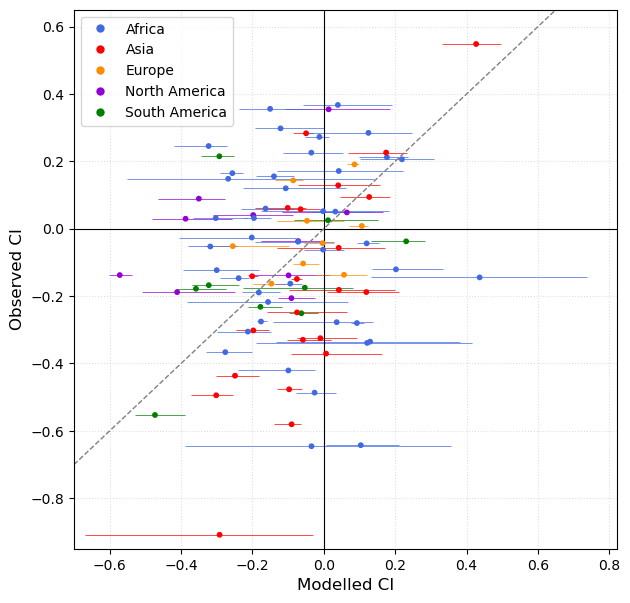

In [116]:
# USER INPUTS
cont_colors = {
    "Africa":"royalblue",
    "Asia":"red",
    "Europe":"darkorange",
    "North America":"darkviolet",
    "South America":"green"
}
plot_xmin = -0.7
plot_xmax = 0.82
plot_ymin = -0.95
plot_ymax = 0.65
point_size = 10
line_width = 0.5

# Plotting table
obs = (combined_metrics[combined_metrics['model']=='observed'][['ISO3', 'CI']].set_index('ISO3').rename(columns={'CI': 'y'}))
avg = (combined_metrics[combined_metrics['model']=='average'][['ISO3', 'CI']].set_index('ISO3').rename(columns={'CI': 'x'}))
rng = (combined_metrics[combined_metrics['model'].isin(['giri', 'jrc', 'wri'])].groupby('ISO3')['CI'].agg(xmin='min', xmax='max'))
continent = (combined_metrics[['ISO3', 'continent']].dropna().drop_duplicates('ISO3').set_index('ISO3'))
plot_df = (obs.join([avg, rng, continent], how='inner').reset_index())
# Add continent color
plot_df['color'] = plot_df['continent'].map(cont_colors).fillna('#7f7f7f')

# Plot
fig, ax = plt.subplots(figsize=(7,7))

# Reference lines
ax.axvline(0, color="black", lw=0.8)
ax.axhline(0, color="black", lw=0.8)
ax.plot([-1,1], [-1,1], ls="--", color="gray", lw=1)

# Range bars (min..max of JRC/GIRI/WRI) at each country’s observed y
mask_bars = plot_df[['xmin','xmax','y']].notna().all(axis=1)
for _, r in plot_df[mask_bars].iterrows():
    ax.hlines(y=r['y'], xmin=r['xmin'], xmax=r['xmax'],
              color=r['color'], lw=line_width, zorder=1)

# Points + labels (average vs observed)
ax.scatter(plot_df['x'], plot_df['y'], s=point_size,
           c=plot_df['color'], zorder=2)

# # Create text labels but don't position them yet
# texts = []
# for _, r in plot_df.iterrows():
#     texts.append(
#         ax.text(r['x'], r['y'], r['ISO3'],
#                 fontsize=8, color=r['color'], alpha=0.9, zorder=6)
#     )

# # Automatically adjust label positions to reduce overlap
# adjust_text(
#     texts, 
#     x=plot_df['x'], y=plot_df['y'],
#     ax=ax,
#     arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.5)
# )

# for _, r in plot_df[mask_bars].iterrows():
#     ax.hlines(y=r['y'], xmin=r['xmin'], xmax=r['xmax'],
#               color='lightgray', lw=2, zorder=1)

# for _, r in plot_df.iterrows():
#     ax.text(r['x']+0.01, r['y']+0.01, r['ISO3'],
#             fontsize=8, color=r['color'], alpha=0.9)

# Axes & cosmetics
ax.set_xlim(plot_xmin,plot_xmax); ax.set_ylim(plot_ymin,plot_ymax)
ax.set_xlabel("Modelled CI", fontsize=12)
ax.set_ylabel("Observed CI", fontsize=12)
ax.grid(True, ls=":", alpha=0.4)

# Legend
handles = [plt.Line2D([0],[0], marker='o', color='none',
                      markerfacecolor=col,
                      markeredgecolor='none',
                      markersize=6, label=name)
           for name, col in cont_colors.items()]
ax.legend(handles=handles, loc="upper left", frameon=True)

# plt.tight_layout(); plt.show()
plt.savefig(r"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\Howden\Write-Up\Paper\Figures\3_observed_modelled\high_res.jpg", dpi=300,bbox_inches='tight')

In [77]:
combined_metrics[combined_metrics['ISO3']=='KEN']

,ISO3,shapeName,CI,model,continent
50,KEN,Kenya,-0.026166,observed,Africa
50,KEN,Kenya,-0.077172,jrc,Africa
50,KEN,Kenya,-0.077172,giri,Africa
50,KEN,Kenya,-0.077172,wri,Africa
43,KEN,Kenya,-0.077172,average,Africa
